In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import re

from sklearn import tree
from sklearn.linear_model import LogisticRegression

In [2]:
# 載入數據至Pandas資料表 DataFrame

dfTrain = pd.DataFrame(pd.read_csv("/share/all/train.csv"))
dfTest = pd.DataFrame(pd.read_csv("/share/all/test.csv"))

dfTrain.head(5) # 看資料表前五行

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 觀察資料

In [3]:
## 將資料內容轉存至共同變數
df = dfTrain.iloc[:, :-1]
df = df.append(dfTest)
target = dfTrain['SalePrice']

In [4]:
# 觀察欄位名 屬性 非空值筆數
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-

In [5]:
#(資料筆數,欄位數)
df.shape

(2919, 80)

In [6]:
# 觀察欄位不重複值
df.apply(lambda x:x.unique().shape[0],axis=0)

Id               2919
MSSubClass         16
MSZoning            6
LotFrontage       129
LotArea          1951
Street              2
Alley               3
LotShape            4
LandContour         4
Utilities           3
LotConfig           5
LandSlope           3
Neighborhood       25
Condition1          9
Condition2          8
BldgType            5
HouseStyle          8
OverallQual        10
OverallCond         9
YearBuilt         118
YearRemodAdd       61
RoofStyle           6
RoofMatl            8
Exterior1st        16
Exterior2nd        17
MasVnrType          5
MasVnrArea        445
ExterQual           4
ExterCond           5
Foundation          6
                 ... 
HalfBath            3
BedroomAbvGr        8
KitchenAbvGr        4
KitchenQual         5
TotRmsAbvGrd       14
Functional          8
Fireplaces          5
FireplaceQu         6
GarageType          7
GarageYrBlt       104
GarageFinish        4
GarageCars          7
GarageArea        604
GarageQual          6
GarageCond

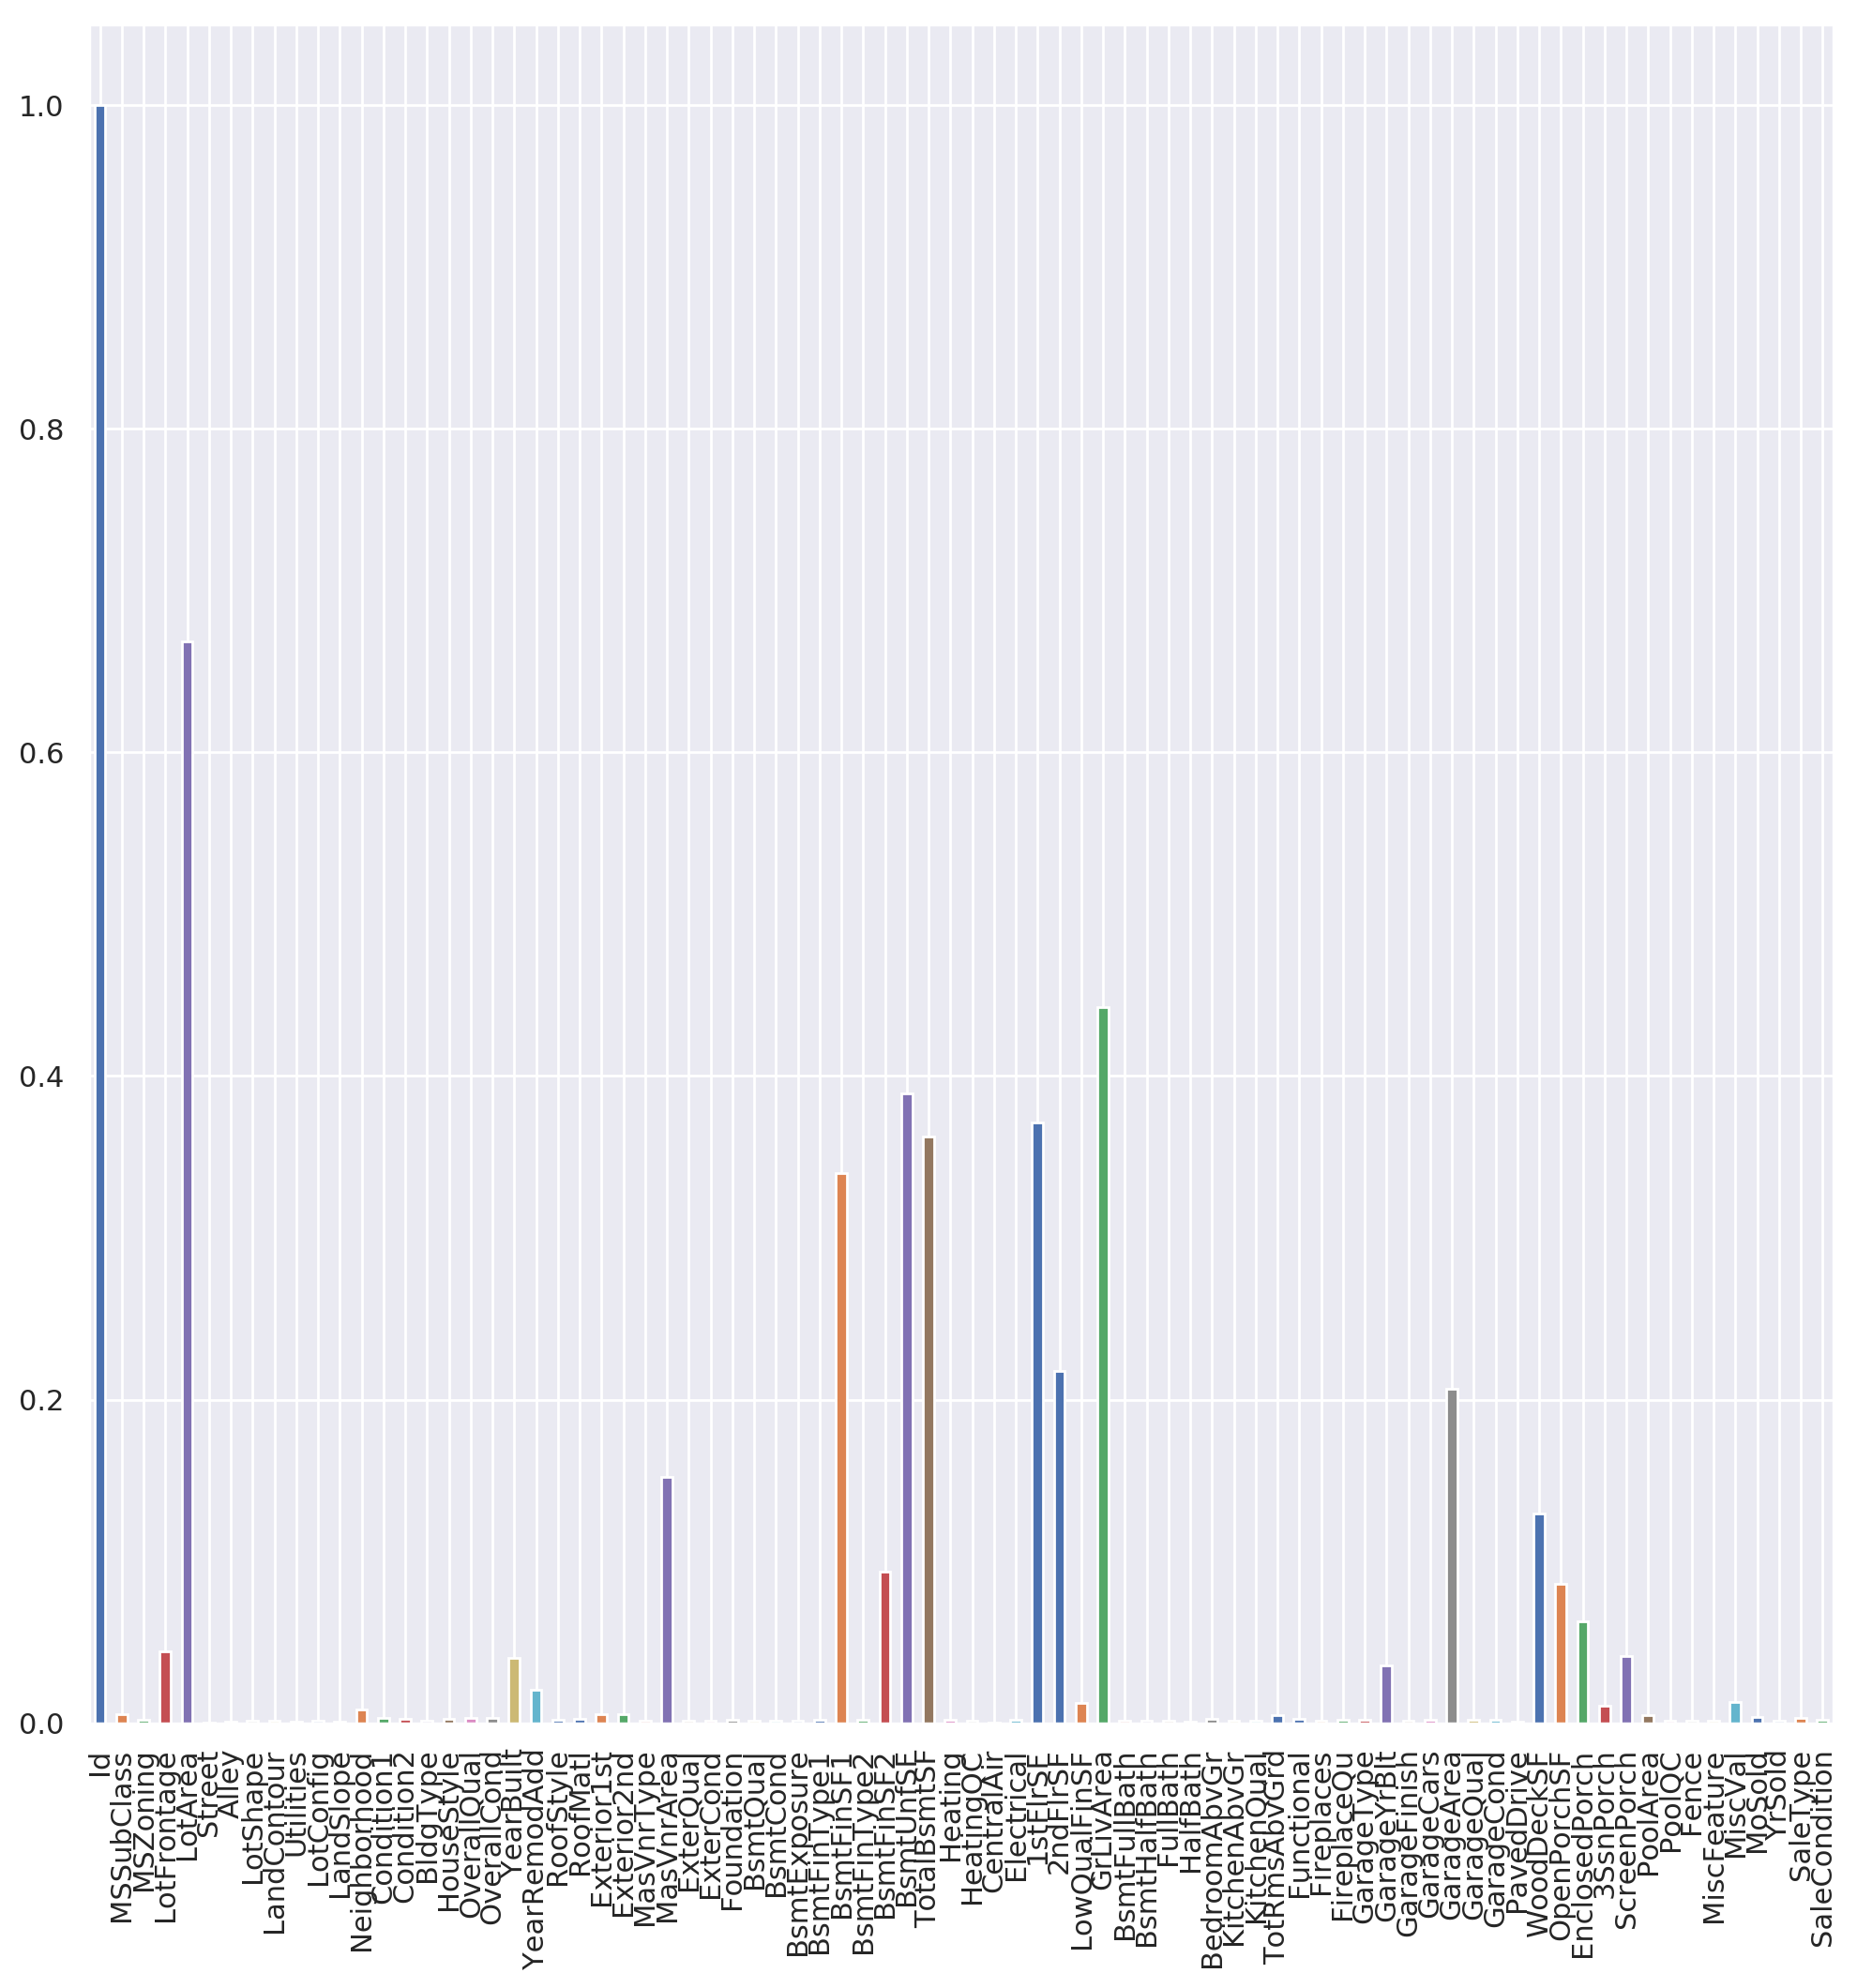

In [7]:
plt.figure(figsize=(12,12),dpi=200)  # 調整圖片尺寸
(df.apply(lambda x:x.unique().shape[0],axis=0)/df.shape[0]).plot(kind='bar');

In [8]:
# 空值數量
df.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
Alley            2721
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
MasVnrArea         23
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         1
TotRmsAbvGrd        0
Functional          2
Fireplaces          0
FireplaceQu      1420
GarageType        157
GarageYrBlt       159
GarageFinish      159
GarageCars          1
GarageArea          1
GarageQual        159
GarageCond

In [9]:
# 空值欄位
df.loc[:,pd.Series(df.isnull().any())]

,MSZoning,LotFrontage,Alley,Utilities,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,SaleType
0,RL,65.0,NaN,AllPub,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,...,2003.0,RFn,2.0,548.0,TA,TA,NaN,NaN,NaN,WD
1,RL,80.0,NaN,AllPub,MetalSd,MetalSd,None,0.0,Gd,TA,...,1976.0,RFn,2.0,460.0,TA,TA,NaN,NaN,NaN,WD
2,RL,68.0,NaN,AllPub,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,...,2001.0,RFn,2.0,608.0,TA,TA,NaN,NaN,NaN,WD
3,RL,60.0,NaN,AllPub,Wd Sdng,Wd Shng,None,0.0,TA,Gd,...,1998.0,Unf,3.0,642.0,TA,TA,NaN,NaN,NaN,WD
4,RL,84.0,NaN,AllPub,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,...,2000.0,RFn,3.0,836.0,TA,TA,NaN,NaN,NaN,WD
5,RL,85.0,NaN,AllPub,VinylSd,VinylSd,None,0.0,Gd,TA,...,1993.0,Unf,2.0,480.0,TA,TA,NaN,MnPrv,Shed,WD
6,RL,75.0,NaN,AllPub,VinylSd,VinylSd,Stone,186.0,Ex,TA,...,2004.0,RFn,2.0,636.0,TA,TA,NaN,NaN,NaN,WD
7,RL,NaN,NaN,AllPub,HdBoard,HdBoard,Stone,240.0,Gd,TA,...,1973.0,RFn,2.0,484.0,TA,TA,NaN,NaN,Shed,WD
8,RM,51.0,NaN,AllPub,BrkFace,Wd Shng,None,0.0,TA,TA,...,1931.0,Unf,2.0,468.0,Fa,TA,NaN,NaN,NaN,WD
9,RL,50.0,NaN,AllPub,MetalSd,MetalSd,None,0.0,TA,TA,...,1939.0,RFn,1.0,205.0,Gd,TA,NaN,NaN,NaN,WD


# 資料清理

In [10]:
# 欄位補0或None
c = ["LotFrontage","GarageYrBlt","GarageCars","BsmtFullBath","BsmtUnfSF","BsmtFinSF1","GarageArea",
     "TotalBsmtSF","BsmtFinSF2","BsmtHalfBath"]

df[c] = df[c].fillna(0)

d = ["Alley","BsmtCond","BsmtQual","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu",
     "GarageType","GarageFinish","GarageQual","GarageCond","KitchenQual"]
df[d] = df[d].fillna('None')

In [11]:
# 特殊欄位補None 原意有值改1? 暫時不變原有資料測試
c = ["PoolQC","Fence"]
df[c] = df[c].fillna('None')

c = ["MiscFeature"]
df[c] = df[c].fillna('None')

In [12]:
# 用眾值填補空值
c = ["MasVnrType","MasVnrArea","Electrical","MSZoning","Utilities","Exterior1st","Exterior2nd","SaleType","Functional"]

for i in c:
    df[i] = df[i].fillna(df[i].mode()[0])

#df["SaleType"].mode()[0] # 觀察眾值

# 觀察資料相依性

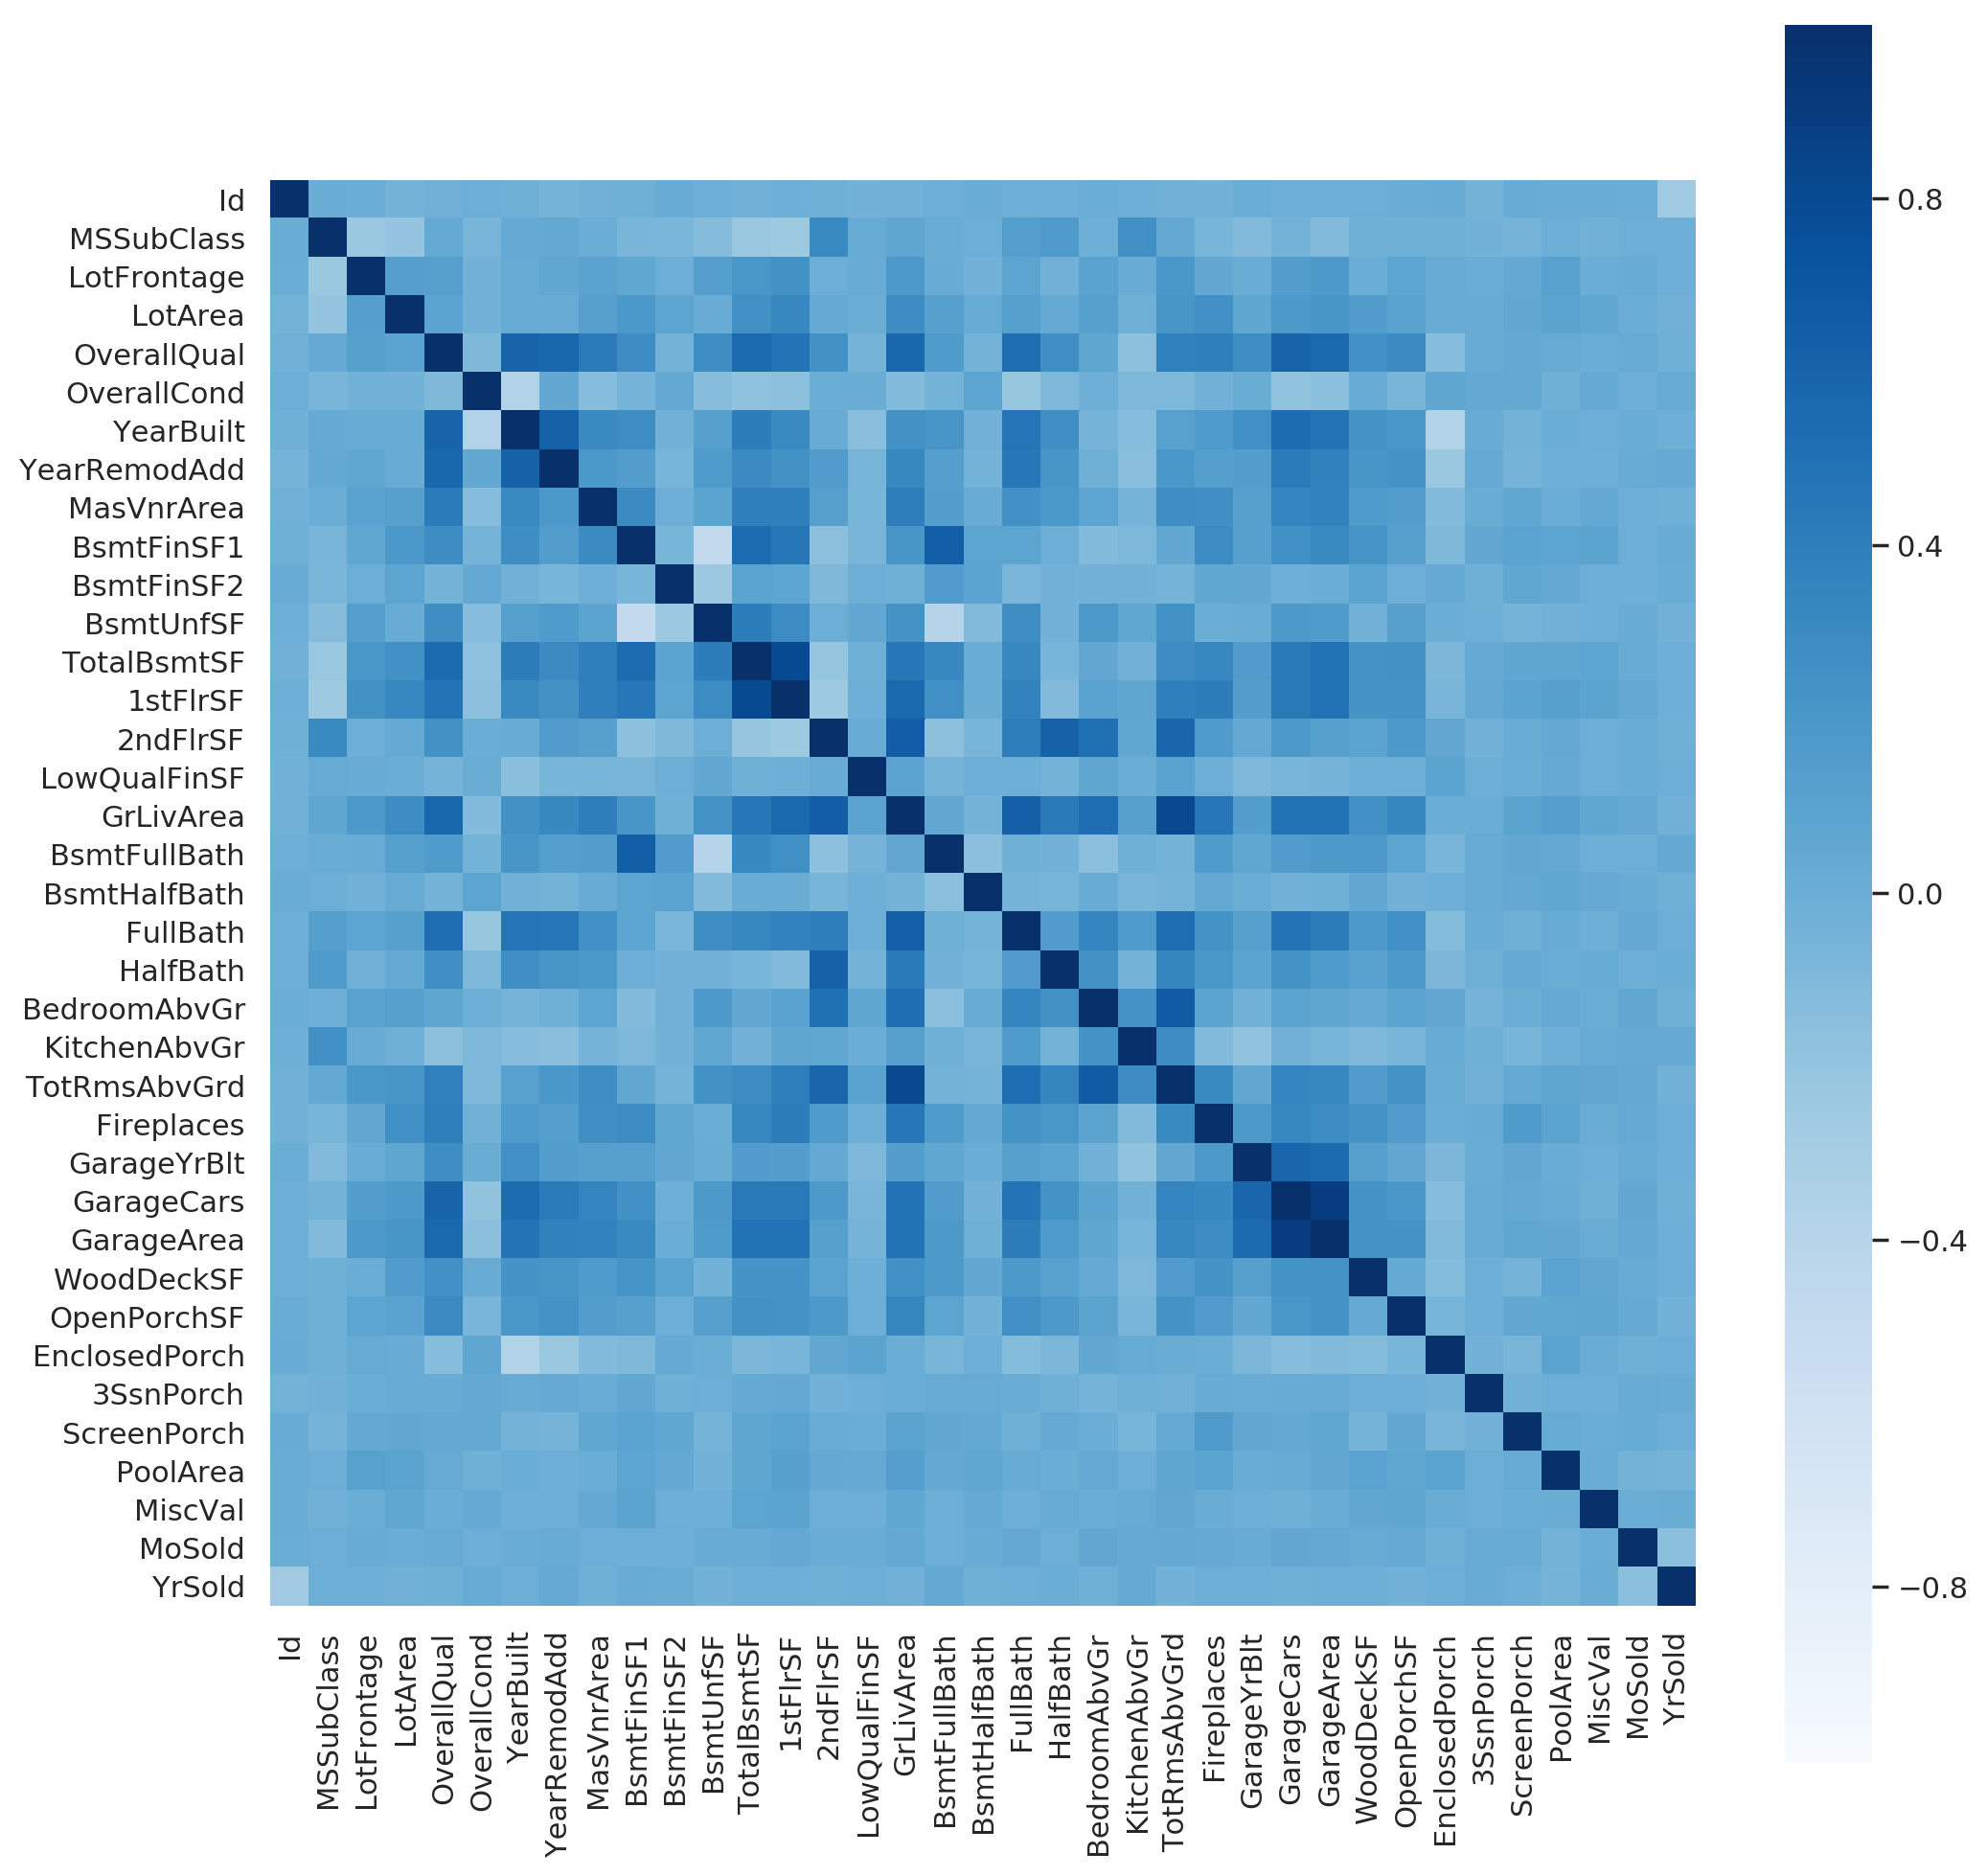

In [13]:
plt.figure(figsize=(12,12),dpi=200)
sns.heatmap( df.corr(),cmap="Blues",   # color
             vmin=-1,                              # lower limit
             vmax=1,                               # upper liomit
             square=True,                       # square 
             annot=None)                        # block of number
plt.show()

# 字串轉類別

In [14]:
df["GarageYrBlt"] = df["GarageYrBlt"].astype(str)
df["MSSubClass"] = df["MSSubClass"].astype(str)

In [15]:
from sklearn.preprocessing import LabelEncoder
c = ["ExterQual","ExterCond","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","HeatingQC",
"CentralAir","KitchenQual","FireplaceQu","GarageFinish","GarageQual","GarageCond","PoolQC","Fence"]

for item in c:
    le = LabelEncoder()
    le.fit(np.unique(df[item].values))
    df[item] = le.transform(df[item])

In [16]:
c=["MSZoning","Street","Alley","LotShape","LandContour","Utilities","LotConfig","LandSlope","Neighborhood",
"Condition1","Condition2","BldgType","HouseStyle","RoofStyle","RoofMatl","Exterior1st","Exterior2nd","MasVnrType",
"Foundation","Heating","Electrical","Functional","GarageType","PavedDrive","MiscFeature","SaleType","SaleCondition"]

a = pd.get_dummies(df[c])
df[a.columns] = a
df = df.drop(c, axis=1)

In [17]:
#還原原始訓練、測試資料集
dfTest = df.iloc[1460:,]
df = df.iloc[:1460,]

In [18]:
# 切割訓練 測試資料
from sklearn.model_selection import train_test_split

x = df.values  ## 原始資料
y = target.values  ## 原始資料
    
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2)

In [19]:
assert train_x.shape[0] == train_y.shape[0],"error, check my data!"

In [20]:
# 資料標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(train_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [21]:
# 觀察標準化結果
np.mean(train_x), np.std(train_x)  

(1.308570314575097e-16, 0.9937040297517031)

# Scikit-learn: Ridge Regression

In [22]:
# 建模
from sklearn.linear_model import Ridge

regressor = Ridge(max_iter=1000000)
model_Ridge = regressor.fit(train_x,train_y)

In [23]:
# 預測
from sklearn.metrics import r2_score
pred_y = model_Ridge.predict(test_x)
r2_score(test_y,pred_y)

0.6324481259166959

# Scikit-learn: Lasso Regression

In [24]:
# 建模
from sklearn.linear_model import Lasso

regressor = Lasso(max_iter=1000000)
%time model_Lasso = regressor.fit(train_x,train_y)

CPU times: user 7.19 s, sys: 0 ns, total: 7.19 s
Wall time: 7.31 s


In [25]:
# 預測
#from sklearn.metrics import r2_score
pred_y = model_Lasso.predict(test_x)
r2_score(test_y,pred_y)

0.6339469103099553

# Scikit-learn: Elastic Net Regression

In [26]:
# 建模
from sklearn.linear_model import ElasticNet
regressor = ElasticNet(max_iter=1000000)
%time model_ElasticNet = regressor.fit(train_x,train_y)

CPU times: user 16.1 ms, sys: 0 ns, total: 16.1 ms
Wall time: 19.1 ms


In [27]:
# 預測
#from sklearn.metrics import r2_score
pred_y = model_ElasticNet.predict(test_x)
r2_score(test_y,pred_y)

0.7199769900660982

# Scikit-learn: 樹演算法(資料不進行標準化)

In [76]:
# 建模
from sklearn.tree import DecisionTreeClassifier

regressor = DecisionTreeClassifier(criterion='entropy',   # 預設為'gini'  #entropy
                                   splitter='best',                       # 預設為'best'  #random
                                   max_depth=12,                     # 樹的深度
                                   min_samples_split=2,             # 分解節點時，最少樣本數 
                                   min_samples_leaf=1,              # 每個節點最少樣本數
                                   #min_weight_fraction_leaf=0.0, # 每個樣本的權重
                                   #max_features=None,             
                                   random_state=2,
                                   #max_leaf_nodes=None,           # 以雜質相對少的方式種樹，None代表無限制
                                   #min_impurity_decrease=0.0,      # 如果分裂將使雜質減少，則分裂節點
                                   #min_impurity_split=None,          # 樹木早期生長的門檻 以前一個參數為主
                                   class_weight=None,          # 權重形式 'balanced' 或 None
                                   presort=False)                         # 是否預先分配數據，加快最佳分裂的發現
model_DTC = regressor.fit(train_x,train_y)

In [77]:
# 預測
from sklearn.metrics import r2_score
pred_y = model_DTC.predict(test_x)
r2_score(test_y,pred_y)

0.6283731669445751

In [78]:
# 觀察屬性值重要性，值越大越重要
print(model_DTC.feature_importances_)

[0.03039334 0.00505324 0.05679207 0.06026449 0.08594569 0.00745476
 0.04691889 0.0218132  0.01269264 0.00117634 0.00125034 0.00911246
 0.00046611 0.02018227 0.01793164 0.01694178 0.0019223  0.00027006
 0.03691262 0.0763726  0.0072622  0.00046611 0.05176682 0.0239712
 0.         0.09314244 0.00211835 0.00039211 0.00267236 0.00948517
 0.00417702 0.         0.00360458 0.01063847 0.00333043 0.00341675
 0.02445736 0.00678092 0.04166255 0.04853015 0.         0.00046611
 0.01053957 0.01009093 0.00223062 0.         0.         0.
 0.         0.00327032 0.00019606 0.01602038 0.01087155 0.
 0.00027006 0.         0.00299116 0.00132434 0.         0.
 0.         0.00093223 0.         0.00392496 0.00087028 0.00027006
 0.01142915 0.00019606 0.00031811 0.00019606 0.00058817 0.
 0.         0.00164245 0.00066217 0.00031811 0.         0.00365905
 0.0006239  0.00019606 0.         0.00019606 0.         0.
 0.00019606 0.         0.00133413 0.         0.00019606 0.00019606
 0.00019606 0.         0.         0.

## 解釋：為何樹的演算法可以做回歸？

# Random Forest regression 隨機森林(資料不進行標準化)

In [109]:
# 建模
from sklearn.ensemble import RandomForestClassifier

regressor = RandomForestClassifier(n_estimators=350,    # 樹的數量
                                   criterion='entropy',                       # 預設為'gini'  'entropy'
                                   #max_depth=None,                   # 預設為None 無限制
                                   #min_samples_split=2,
                                   #min_samples_leaf=1,
                                   #min_weight_fraction_leaf=0.0,
                                   max_features='sqrt',                 # 尋找最佳分割所考慮的功能 'auto' 'sqrt' 'log2' 'None' int float
                                   #max_leaf_nodes=None,
                                   #min_impurity_decrease=0.0,
                                   #min_impurity_split=None,
                                   bootstrap=True,                      # 種樹時是否使用 bootstrap 的樣本
                                   #oob_score=False,
                                   n_jobs=-1,                               # 最大工作數 -1代表使用全部的處理器
                                   random_state=None,
                                   #verbose=0,                              # 在擬合和預設時顯示控制詳細程度 (只是顯示步驟而已 對預測確率沒幫助)
                                   warm_start=False,                   # 設為True時，是以補充隨機森林模型的方式運算
                                   class_weight='balanced')                 # 'None' 'balanced' 'balanced_subsample'
%time model_RFC = regressor.fit(train_x,train_y)

CPU times: user 9.21 s, sys: 0 ns, total: 9.21 s
Wall time: 9.3 s


In [110]:
# 預測
from sklearn.metrics import r2_score
pred_y = model_RFC.predict(test_x)
%time r2_score(test_y,pred_y)

CPU times: user 168 µs, sys: 0 ns, total: 168 µs
Wall time: 171 µs


0.7394567928806142

# 隨機森林的特徵選取

 1) GrLivArea                      0.043126
 2) 1stFlrSF                       0.037250
 3) GarageArea                     0.036241
 4) YearBuilt                      0.035453
 5) LotArea                        0.034904
 6) TotalBsmtSF                    0.034886
 7) BsmtUnfSF                      0.032222
 8) YearRemodAdd                   0.031560
 9) GarageYrBlt                    0.031175
10) BsmtFinSF1                     0.030530
11) LotFrontage                    0.030330
12) Id                             0.029733
13) OpenPorchSF                    0.027643
14) OverallQual                    0.024367
15) WoodDeckSF                     0.023664
16) TotRmsAbvGrd                   0.022443
17) MoSold                         0.022019
18) YrSold                         0.020813
19) MasVnrArea                     0.017562
20) 2ndFlrSF                       0.017284
21) MSSubClass                     0.016863
22) BsmtFinType1                   0.014628
23) GarageFinish                

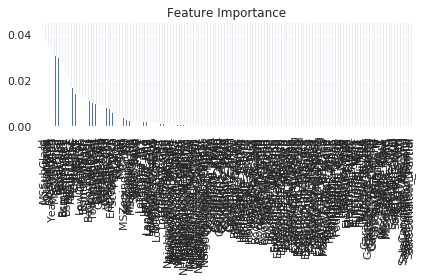

In [111]:
# 畫出feature importance
feat_labels = df.columns  # 取欄位名
importances = model_RFC.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(train_x.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(train_x.shape[1]),
       importances[indices],
       align='center')
plt.xticks(range(train_x.shape[1]),
           feat_labels,
           rotation=90)
plt.xlim([-1, train_x.shape[1]])
plt.tight_layout()
plt.show()

In [112]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(model_RFC, threshold=0.0001, prefit=True)  # 特徵重要性門檻值設為0.01
x_selected = sfm.transform(train_x)
print('Number of samples that meet this criterion:',
     x_selected.shape[0])

Number of samples that meet this criterion: 1168


In [113]:
for f in range(x_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

 1) GrLivArea                      0.043126
 2) 1stFlrSF                       0.037250
 3) GarageArea                     0.036241
 4) YearBuilt                      0.035453
 5) LotArea                        0.034904
 6) TotalBsmtSF                    0.034886
 7) BsmtUnfSF                      0.032222
 8) YearRemodAdd                   0.031560
 9) GarageYrBlt                    0.031175
10) BsmtFinSF1                     0.030530
11) LotFrontage                    0.030330
12) Id                             0.029733
13) OpenPorchSF                    0.027643
14) OverallQual                    0.024367
15) WoodDeckSF                     0.023664
16) TotRmsAbvGrd                   0.022443
17) MoSold                         0.022019
18) YrSold                         0.020813
19) MasVnrArea                     0.017562
20) 2ndFlrSF                       0.017284
21) MSSubClass                     0.016863
22) BsmtFinType1                   0.014628
23) GarageFinish                

In [114]:
# 保留重要特徵值欄位
fea_imp = []
for f in range(x_selected.shape[1]):
    fea_imp.append(feat_labels[indices[f]])

#d=set([i.split('_',1)[0] for i in fea_imp])
#fea_imp= list(d)
len(fea_imp)

164

# XGBoosting(資料不進行標準化)

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
xgb.__version__

'0.80'

In [122]:
%%time
from sklearn.model_selection import GridSearchCV, cross_val_score

#cv_params = {'n_estimators':[500,550,600,650]}
#cv_params = {'max_depth':range(4,9),'min_child_weight':range(1,6)}
#cv_params = {'gamma':[0,0.1,0.2,0.3,0.4,0.5]}
#cv_params = {'subsample':[0.6,0.7,0.8,0.9],'colsample_bytree':[0.6,0.7,0.8,0.9]}
#cv_params = {'reg_alpha':[0,0.05,0.1,1,2,3],'reg_lambda':[0,0.05,0.1,1,2,3]}
#cv_params = {'learning_rate':[0.1,0.15,0.2,0.25,0.3]}
other_params = {'learning_rate':0.15,'n_estimators':600,'max_depth':4,'min_child_weight':1,'seed':0,
              'subsample':0.6,'colsample_bytree':0.6,'gamma':0,'reg_alpha':3,'reg_lambda':0.05}

model_xgboost = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator = model_xgboost, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=-1)
optimized_GBM.fit(train_x,train_y)
evalute_result = optimized_GBM.grid_scores_
print('each round result:{0}'.format(evalute_result))
print('best params:{0}'.format(optimized_GBM.best_params_))
print('best model score:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   50.7s finished


each round result:[mean: 0.88283, std: 0.04078, params: {'learning_rate': 0.1}, mean: 0.88781, std: 0.03586, params: {'learning_rate': 0.15}, mean: 0.87210, std: 0.03554, params: {'learning_rate': 0.2}, mean: 0.86663, std: 0.02950, params: {'learning_rate': 0.25}, mean: 0.83758, std: 0.04087, params: {'learning_rate': 0.3}]
best params:{'learning_rate': 0.15}
best model score:0.8878081869673304
CPU times: user 51.7 s, sys: 0 ns, total: 51.7 s
Wall time: 53.2 s


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [123]:
%%time
other_params = {'learning_rate':0.15,'n_estimators':600,'max_depth':4,'min_child_weight':1,'seed':0,
              'subsample':0.6,'colsample_bytree':0.6,'gamma':0,'reg_alpha':3,'reg_lambda':0.05}

model_xgboost = xgb.XGBRegressor(**other_params)
model_xgboost.fit(train_x,train_y)

CPU times: user 2.49 s, sys: 0 ns, total: 2.49 s
Wall time: 2.52 s


# XGBoosting: 以$R^2$評估回歸結果

In [124]:
from sklearn.metrics import r2_score

pred_y = model_xgboost.predict(test_x)
r2_score(test_y,pred_y)

0.9009536994075122

# XGBoost: 檢視各欄位重要性

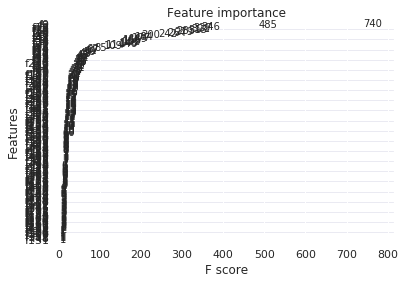

In [125]:
from xgboost import plot_importance

plot_importance(model_xgboost)
plt.show()

# 找出房價離群值

In [126]:
max_stdPrice = np.mean(y) + np.std(y) * 3
min_stdPrice = np.mean(y) - np.std(y) * 3
outlier = []
for i in range(len(y)):
    if y[i] > max_stdPrice:
        outlier += [i]
    elif y[i] < min_stdPrice:
        outlier += [i]

In [127]:
# 刪除離群值資料
df_new = df.drop(outlier, axis = 0)
target_new = target.drop(outlier, axis = 0)

In [128]:
# 選取重要特徵值欄位
df_new = df_new[fea_imp]
dfTest = dfTest[fea_imp]

In [129]:
# 切割訓練 測試資料
from sklearn.model_selection import train_test_split

x2 = df_new.values  ## 原始資料
y2 = target_new.values  ## 原始資料
    
train_x2, test_x2, train_y2, test_y2 = train_test_split(x2, y2, test_size=0.2)

x2.shape

(1438, 164)

In [130]:
assert train_x2.shape[0] == train_y2.shape[0],"error, check my data!"

In [131]:
# 資料標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(train_x2)

train_x2 = scaler.transform(train_x2)
test_x2 = scaler.transform(test_x2)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [132]:
# 觀察標準化結果
np.mean(train_x2), np.std(train_x2)  

(8.733440505481879e-18, 1.0000000000000007)

# Scikit-learn: Ridge Regression

In [133]:
# 建模
from sklearn.linear_model import Ridge

regressor = Ridge(max_iter=1000000)
model_Ridge = regressor.fit(train_x2,train_y2)

In [135]:
# 預測
from sklearn.metrics import r2_score
pred_y2 = model_Ridge.predict(test_x2)
r2_score(test_y2,pred_y2)

0.8893709107804005

In [137]:
# 建模 & 自動調參
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score

al=[0.01,0.1,0.3,0.5,0.8,1.0]
rs=[None,0,1,3]
max_i=[1000000]
kwargs={'alpha':al,'max_iter':max_i,'random_state':rs}

regressor = GridSearchCV(estimator=Ridge(), param_grid=kwargs, n_jobs=-1)  ## 參數：cv=n n則交叉驗證
%time model_Ridge = regressor.fit(train_x2,train_y2)

CPU times: user 212 ms, sys: 0 ns, total: 212 ms
Wall time: 217 ms


In [138]:
# 預測
from sklearn.metrics import r2_score
pred_y2 = model_Ridge.predict(test_x2)
r2_score(test_y2,pred_y2)

0.8893709107804005

# Scikit-learn: Lasso Regression

In [139]:
# 建模
from sklearn.linear_model import Lasso

regressor = Lasso(max_iter=1000000)
%time model_Lasso = regressor.fit(train_x2,train_y2)

CPU times: user 1.03 s, sys: 0 ns, total: 1.03 s
Wall time: 1.04 s


In [140]:
# 預測
#from sklearn.metrics import r2_score
pred_y2 = model_Lasso.predict(test_x2)
r2_score(test_y2,pred_y2)

0.8891406858843687

In [141]:
# 建模 & 自動調參
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score

al=[0.1,0.5,1.0]
rs=[None,0,1]
max_i=[1000000]
kwargs={'alpha':al,'max_iter':max_i,'random_state':rs}

regressor = GridSearchCV(estimator=Lasso(), param_grid=kwargs, n_jobs=-1)  ## 參數：cv=n n則交叉驗證
%time model_Lasso = regressor.fit(train_x2,train_y2)

CPU times: user 1min 15s, sys: 0 ns, total: 1min 15s
Wall time: 1min 16s


In [142]:
# 預測
#from sklearn.metrics import r2_score
pred_y2 = model_Lasso.predict(test_x2)
r2_score(test_y2,pred_y2)

0.8891406858843687

# Scikit-learn: Elastic Net Regression

In [143]:
# 建模
from sklearn.linear_model import ElasticNet
regressor = ElasticNet(max_iter=1000000)
%time model_ElasticNet = regressor.fit(train_x2,train_y2)

CPU times: user 16.3 ms, sys: 0 ns, total: 16.3 ms
Wall time: 16.8 ms


In [145]:
# 預測
#from sklearn.metrics import r2_score
pred_y2 = model_ElasticNet.predict(test_x2)
r2_score(test_y2,pred_y2)

0.8920763793018236

In [146]:
# 建模 & 自動調參
#####    吃資源  慎用
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, cross_val_score

al=[0.1,0.5,1.0]
l1=[0,0.5,1.0]
rs=[None,0,3]
max_i=[1000000]
kwargs={'alpha':al,'l1_ratio':l1,'max_iter':max_i,'random_state':rs}

regressor = GridSearchCV(estimator=ElasticNet(), param_grid=kwargs, n_jobs=-1)  ## 參數：cv=n n則交叉驗證
%time model_ElasticNet = regressor.fit(train_x2,train_y2)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

KeyboardInterrupt: 

In [147]:
# 預測
#from sklearn.metrics import r2_score
pred_y = model_ElasticNet.predict(test_x2)
r2_score(test_y2,pred_y2)

0.8920763793018236

# Scikit-learn: 樹演算法

In [189]:
# 建模
from sklearn.tree import DecisionTreeClassifier

regressor = DecisionTreeClassifier(criterion='entropy',   # 預設為'gini'  #entropy
                                   splitter='best',                       # 預設為'best'  #random
                                   max_depth=12,                     # 樹的深度
                                   #min_samples_split=2,             # 分解節點時，最少樣本數 
                                   #min_samples_leaf=1,              # 每個節點最少樣本數
                                   #min_weight_fraction_leaf=0.0, # 每個樣本的權重
                                   #max_features=None,             
                                   random_state=2,
                                   #max_leaf_nodes=None,           # 以雜質相對少的方式種樹，None代表無限制
                                   #min_impurity_decrease=0.0,      # 如果分裂將使雜質減少，則分裂節點
                                   #min_impurity_split=None,          # 樹木早期生長的門檻 以前一個參數為主
                                   class_weight='balanced' ,          # 權重形式 'balanced' 或 None
                                   presort=False)                         # 是否預先分配數據，加快最佳分裂的發現
%time model_DTC = regressor.fit(train_x2,train_y2)

CPU times: user 510 ms, sys: 0 ns, total: 510 ms
Wall time: 518 ms


In [190]:
# 預測
#from sklearn.metrics import r2_score
pred_y2 = model_DTC.predict(test_x2)
r2_score(test_y2,pred_y2)

0.6848372060689054

In [ ]:
# 建模 & 自動調參
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

crit=['entropy']
spli=['best']
m_dep=[5,10,15]
rs=[None,0,1,3]
cl=[None,'balanced']
kwargs={'criterion':crit,'splitter':spli,'max_depth':m_dep,'random_state':rs,'class_weight':cl}

regressor = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=kwargs, n_jobs=-1)  ## 參數：cv=n n則交叉驗證
%time model_DTC = regressor.fit(train_x2,train_y2)

In [ ]:
# 預測
#from sklearn.metrics import r2_score
pred_y2 = model_DTC.predict(test_x2)
r2_score(test_y2,pred_y2)

In [ ]:
# 觀察屬性值重要性，值越大越重要
print(model_DTC.feature_importances_)

# Random Forest regression 隨機森林

In [220]:
# 建模
from sklearn.ensemble import RandomForestClassifier

regressor = RandomForestClassifier(n_estimators=400,    # 樹的數量
                                   criterion='entropy',                       # 預設為'gini'  'entropy'
                                   #max_depth=None,                   # 預設為None 無限制
                                   #min_samples_split=2,
                                   #min_samples_leaf=1,
                                   #min_weight_fraction_leaf=0.0,
                                   max_features='auto',                 # 尋找最佳分割所考慮的功能 'auto' 'sqrt' 'log2' 'None' int float
                                   #max_leaf_nodes=None,
                                   #min_impurity_decrease=0.0,
                                   #min_impurity_split=None,
                                   bootstrap=True,                      # 種樹時是否使用 bootstrap 的樣本
                                   #oob_score=False,
                                   n_jobs=-1,                               # 最大工作數 -1代表使用全部的處理器
                                   random_state=None)
                                   #verbose=0,                              # 在擬合和預設時顯示控制詳細程度 (只是顯示步驟而已 對預測確率沒幫助)
                                   #warm_start=False)                   # 設為True時，是以補充隨機森林模型的方式運算
                                   #class_weight=None)                 # 'None' 'balanced' 'balanced_subsample'
%time model_RFC = regressor.fit(train_x2,train_y2)

CPU times: user 10.3 s, sys: 320 ms, total: 10.6 s
Wall time: 11.5 s


In [221]:
# 預測
#from sklearn.metrics import r2_score
pred_y2 = model_RFC.predict(test_x2)
%time r2_score(test_y2,pred_y2)

CPU times: user 168 µs, sys: 4 µs, total: 172 µs
Wall time: 175 µs


0.7944089108223813

In [ ]:
# 建模 & 自動調參
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

n=[100,150,200]
crit=['gini','entropy']
boo=[True,False]
rs=[None,0,1,3]
kwargs={'n_estimators':n,'criterion':crit,'bootstrap':boo,'random_state':rs}

regressor = GridSearchCV(estimator=RandomForestClassifier(), param_grid=kwargs, n_jobs=-1)  ## 參數：cv=n n則交叉驗證
%time model_RFC = regressor.fit(train_x2,train_y2)

In [ ]:
# 預測
#from sklearn.metrics import r2_score
pred_y2 = model_RFC.predict(test_x2)
%time r2_score(test_y2,pred_y2)

# XGBoosting

In [229]:
%%time
from sklearn.model_selection import GridSearchCV, cross_val_score

#cv_params = {'n_estimators':[400,450,500,550]}
#cv_params = {'max_depth':range(3,7),'min_child_weight':range(1,4)}
#cv_params = {'gamma':[0,0.1,0.2,0.3,0.4,0.5,0.6]}
#cv_params = {'subsample':[0.6,0.7,0.8,0.9],'colsample_bytree':[0.6,0.7,0.8,0.9]}
#cv_params = {'reg_alpha':[0,0.05,0.1,1,2,3],'reg_lambda':[0,0.05,0.1,1,2,3]}
#cv_params = {'learning_rate':[0.1,0.15,0.2,0.25,0.3]}
other_params = {'learning_rate':0.1,'n_estimators':400,'max_depth':3,'min_child_weight':1,'seed':0,
              'subsample':0.9,'colsample_bytree':0.6,'gamma':0,'reg_alpha':0.1,'reg_lambda':3}

model_xgboost = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator = model_xgboost, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=-1)
optimized_GBM.fit(train_x2,train_y2)
evalute_result = optimized_GBM.grid_scores_
print('each round result:{0}'.format(evalute_result))
print('best params:{0}'.format(optimized_GBM.best_params_))
print('best model score:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   16.7s finished


each round result:[mean: 0.89584, std: 0.01970, params: {'learning_rate': 0.1}, mean: 0.89280, std: 0.02193, params: {'learning_rate': 0.15}, mean: 0.88698, std: 0.02618, params: {'learning_rate': 0.2}, mean: 0.87822, std: 0.02992, params: {'learning_rate': 0.25}, mean: 0.87488, std: 0.03047, params: {'learning_rate': 0.3}]
best params:{'learning_rate': 0.1}
best model score:0.8958437147506321
CPU times: user 17.3 s, sys: 17.3 ms, total: 17.3 s
Wall time: 17.5 s


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [236]:
%%time
other_params = {'learning_rate':0.1,'n_estimators':400,'max_depth':3,'min_child_weight':1,'seed':0,
              'subsample':0.9,'colsample_bytree':0.6,'gamma':0,'reg_alpha':0.1,'reg_lambda':3}

model_xgboost = xgb.XGBRegressor(**other_params)
model_xgboost.fit(train_x2,train_y2)

CPU times: user 840 ms, sys: 0 ns, total: 840 ms
Wall time: 850 ms


In [237]:
#from sklearn.metrics import r2_score
pred_y2 = model_xgboost.predict(test_x2)
r2_score(test_y2,pred_y2)

0.919755636123094

# PCA降維後再做XGBoost

In [233]:
from sklearn.decomposition import PCA

In [234]:
%%time
comp=range(130,160)
res=[]
for c in comp:
    pca = PCA(n_components=c)  # 模型會把資料投影至一個方向
    pca = pca.fit(x)  # fit資料，模型會根據資料特性，來找出恰當的方向向量
    unit_vec = pca.components_  # 找到方向向量
    reduced_df = pca.transform(x)
    train_x_PCA, test_x_PCA, train_y_PCA, test_y_PCA = train_test_split(reduced_df, y, test_size=0.2)
    
    # 給予模型參數，告知演算法該如何訓練模型
    other_params = {'learning_rate':0.1,'n_estimators':400,'max_depth':3,'min_child_weight':1,'seed':0,
              'subsample':0.9,'colsample_bytree':0.6,'gamma':0,'reg_alpha':0.1,'reg_lambda':3}
    model_xgboost = xgb.XGBRegressor(**other_params)
    model_xgboost.fit(train_x_PCA,train_y_PCA)
    pred_y_PCA = model_xgboost.predict(test_x_PCA)
    r2 = r2_score(test_y_PCA,pred_y_PCA)
    res.append((c, r2 , model_xgboost))

CPU times: user 54.1 s, sys: 64.8 ms, total: 54.2 s
Wall time: 55.9 s


In [235]:
df_res = pd.DataFrame(res, columns=['n_components','r2_score','model'])
df_res

,n_components,r2_score,model
0,130,0.868350,"XGBRegressor(base_score=0.5, booster='gbtree',..."
1,131,0.837592,"XGBRegressor(base_score=0.5, booster='gbtree',..."
2,132,0.865162,"XGBRegressor(base_score=0.5, booster='gbtree',..."
3,133,0.831742,"XGBRegressor(base_score=0.5, booster='gbtree',..."
4,134,0.800237,"XGBRegressor(base_score=0.5, booster='gbtree',..."
5,135,0.811401,"XGBRegressor(base_score=0.5, booster='gbtree',..."
6,136,0.852788,"XGBRegressor(base_score=0.5, booster='gbtree',..."
7,137,0.823299,"XGBRegressor(base_score=0.5, booster='gbtree',..."
8,138,0.866693,"XGBRegressor(base_score=0.5, booster='gbtree',..."
9,139,0.907190,"XGBRegressor(base_score=0.5, booster='gbtree',..."


In [ ]:
pca = PCA(n_components=47)  # 模型會把資料投影至一個方向
pca = pca.fit(x)  # fit資料，模型會根據資料特性，來找出恰當的方向向量
unit_vec = pca.components_  # 找到方向向量
reduced_df = pca.transform(x) # 將資料投影到找出來的方向向量上
# reduced_df即為降維後的資料
reduced_df.shape

# test.csv資料預測

In [248]:
dfTest["GarageYrBlt"] = dfTest["GarageYrBlt"].astype(float)
dfTest["MSSubClass"] = dfTest["MSSubClass"].astype(float)
dfTest["GarageYrBlt"]

0       1961.0
1       1958.0
2       1997.0
3       1998.0
4       1992.0
5       1993.0
6       1992.0
7       1998.0
8       1990.0
9       1970.0
10      1999.0
11      1971.0
12      1997.0
13      1975.0
14      1975.0
15      2009.0
16      2009.0
17      2005.0
18      2005.0
19      2003.0
20      2002.0
21      2006.0
22      2005.0
23      2006.0
24      2004.0
25      2004.0
26      1998.0
27      2005.0
28      2009.0
29      2005.0
         ...  
1429    1925.0
1430    1957.0
1431       0.0
1432       0.0
1433       0.0
1434    2005.0
1435    2004.0
1436    1979.0
1437    1978.0
1438    2001.0
1439    1975.0
1440    1958.0
1441    2000.0
1442    2005.0
1443    2005.0
1444    1951.0
1445    1997.0
1446    1977.0
1447    1968.0
1448    1970.0
1449       0.0
1450    1972.0
1451    1969.0
1452    1970.0
1453       0.0
1454       0.0
1455    1970.0
1456    1960.0
1457       0.0
1458    1993.0
Name: GarageYrBlt, Length: 1459, dtype: float64

In [249]:
### XGBoost
pred_xgboost = model_xgboost.predict(dfTest)

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163'] ['GrLivArea', '1stFlrSF', 'GarageArea', 'YearBuilt', 'LotArea', 'TotalBsmtSF', 'BsmtUnfSF', 'YearRemodAdd', 'GarageYrBlt', 'BsmtFinSF1', 'LotFrontage', 'Id', 'OpenPorchSF', 'OverallQual', 'WoodDeckSF', 'TotRmsAbvGrd', 'MoSold', 'YrSold', 'MasVnrArea', '2ndFlrSF', 'MSSubClass', 'BsmtFinType1', 'GarageFinish', 'ExterQual', 'LotShape_Reg', 'Fireplaces', 'BsmtQual', 'KitchenQual', 'BsmtExposure', 'FireplaceQu', 'GarageCars', 'HeatingQC', 'Exterior2nd_VinylSd', 'MasVnrType_None', 'BsmtFullBath', 'OverallCond', 'HouseStyle_1Story', 'GarageType_Attchd', 'FullBath', 'BedroomAbvGr', 'LotShape_IR1', 'HalfBath', 'Exterior1st_VinylSd', 'Foundation_PConc', 'MasVnrType_BrkFace', 'LotConfig_Inside', 'Foundation_CBlock', 'HouseStyle_2Story', 'GarageType_Detchd', 'RoofStyle_Gable', 'SaleCondition_Normal', 'RoofStyle_Hip', 'Fence', 'MSZoning_RL', 'SaleType_WD', 'LotConfig_Corner', 'SaleCondition_Partial', 'Exterior1st_MetalSd', 'SaleType_New', 'Exterior2nd_MetalSd', 'EnclosedPorch', 'Neighborhood_CollgCr', 'Neighborhood_NAmes', 'MSZoning_RM', 'BsmtFinType2', 'Exterior1st_Wd Sdng', 'BldgType_1Fam', 'Exterior2nd_Wd Sdng', 'MasVnrType_Stone', 'Exterior1st_HdBoard', 'Foundation_BrkTil', 'Exterior2nd_HdBoard', 'GarageQual', 'LandContour_Lvl', 'Condition1_Norm', 'ExterCond', 'HouseStyle_1.5Fin', 'Neighborhood_Somerst', 'BsmtCond', 'GarageType_BuiltIn', 'Neighborhood_NridgHt', 'BsmtFinSF2', 'Electrical_SBrkr', 'BldgType_TwnhsE', 'GarageCond', 'ScreenPorch', 'CentralAir', 'MSZoning_FV', 'Neighborhood_OldTown', 'Exterior2nd_Plywood', 'LotConfig_CulDSac', 'PavedDrive_Y', 'Neighborhood_Gilbert', 'Electrical_FuseA', 'SaleCondition_Abnorml', 'Exterior1st_Plywood', 'Alley_None', 'PavedDrive_N', 'Neighborhood_Edwards', 'Exterior1st_CemntBd', 'Exterior2nd_CmentBd', 'LandSlope_Gtl', 'Functional_Typ', 'Neighborhood_SawyerW', 'LandContour_HLS', 'Neighborhood_Timber', 'Neighborhood_BrkSide', 'BsmtHalfBath', 'Neighborhood_NoRidge', 'Condition1_Feedr', 'Neighborhood_Crawfor', 'LandContour_Bnk', 'GarageType_None', 'Neighborhood_NWAmes', 'LandSlope_Mod', 'Exterior1st_BrkFace', 'KitchenAbvGr', 'LotShape_IR2', 'LotConfig_FR2', 'Alley_Pave', 'MiscFeature_None', 'MiscVal', 'Neighborhood_Sawyer', 'Condition1_Artery', 'HouseStyle_SLvl', 'MiscFeature_Shed', 'SaleType_COD', 'BldgType_Twnhs', 'Neighborhood_Mitchel', 'Neighborhood_IDOTRR', 'Heating_GasA', 'Alley_Grvl', 'Condition1_RRAn', 'Neighborhood_StoneBr', 'BldgType_Duplex', 'LandContour_Low', 'Exterior2nd_BrkFace', 'Neighborhood_Blmngtn', 'LowQualFinSF', 'Exterior2nd_Stucco', 'Functional_Min2', 'Exterior2nd_Wd Shng', 'Condition1_PosN', 'HouseStyle_SFoyer', 'Functional_Min1', 'Foundation_Slab', '3SsnPorch', 'PavedDrive_P', 'Exterior1st_Stucco', 'BldgType_2fmCon', 'LotShape_IR3', 'Neighborhood_ClearCr', 'Neighborhood_SWISU', 'Exterior1st_WdShing', 'Electrical_FuseF', 'Neighborhood_Veenker', 'MasVnrType_BrkCmn', 'RoofMatl_CompShg', 'SaleCondition_Alloca', 'Functional_Mod', 'GarageType_Basment', 'Neighborhood_MeadowV', 'Neighborhood_BrDale', 'SaleCondition_Family']
expected f71, f62, f155, f96, f72, f115, f87, f142, f79, f13, f112, f50, f161, f25, f28, f39, f84, f139, f140, f55, f111, f48, f157, f117, f32, f29, f123, f95, f37, f74, f102, f58, f128, f130, f135, f97, f118, f113, f27, f107, f44, f143, f70, f18, f57, f99, f20, f132, f7, f76, f38, f81, f6, f16, f98, f138, f159, f67, f108, f47, f61, f129, f10, f64, f26, f124, f121, f92, f8, f150, f158, f66, f120, f141, f154, f19, f152, f11, f17, f68, f52, f2, f31, f137, f65, f3, f75, f145, f100, f109, f21, f136, f147, f49, f134, f83, f116, f90, f133, f42, f24, f73, f89, f4, f69, f36, f149, f125, f14, f40, f43, f151, f110, f122, f34, f54, f148, f114, f131, f103, f1, f156, f53, f93, f46, f22, f41, f78, f104, f33, f35, f82, f85, f162, f56, f88, f144, f101, f23, f9, f105, f60, f160, f106, f30, f63, f51, f59, f80, f77, f86, f0, f153, f146, f163, f91, f119, f45, f94, f15, f126, f12, f127, f5 in input data
training data did not have the following fields: MSSubClass, GarageCond, HouseStyle_1Story, BldgType_1Fam, Fireplaces, Condition1_Feedr, Foundation_PConc, Neighborhood_SawyerW, MasVnrType_None, BsmtUnfSF, TotalBsmtSF, YrSold, MasVnrArea, Exterior2nd_Plywood, PavedDrive_P, GarageCars, SaleCondition_Family, BldgType_TwnhsE, LandContour_Low, Exterior1st_BrkFace, Exterior1st_CemntBd, YearBuilt, Heating_GasA, BsmtQual, Neighborhood_NridgHt, LotConfig_Corner, LotConfig_CulDSac, RoofStyle_Hip, KitchenQual, SaleCondition_Abnorml, Functional_Mod, 1stFlrSF, LotShape_Reg, Condition1_RRAn, YearRemodAdd, Electrical_FuseA, Neighborhood_NoRidge, HouseStyle_SFoyer, Electrical_SBrkr, HouseStyle_SLvl, OpenPorchSF, 2ndFlrSF, Exterior2nd_MetalSd, MasVnrType_BrkFace, GarageType_Attchd, BldgType_2fmCon, Exterior2nd_Wd Shng, HeatingQC, Foundation_BrkTil, LandContour_Bnk, BsmtFinType2, Neighborhood_Veenker, LotConfig_FR2, BsmtFinType1, Exterior1st_HdBoard, GarageArea, BsmtExposure, LandSlope_Mod, BldgType_Duplex, ExterQual, MoSold, Neighborhood_StoneBr, Exterior2nd_VinylSd, Neighborhood_NWAmes, GarageQual, 3SsnPorch, SaleType_New, Alley_Pave, Exterior2nd_HdBoard, FullBath, BsmtHalfBath, Neighborhood_Sawyer, FireplaceQu, ExterCond, LotConfig_Inside, LandSlope_Gtl, GarageType_Detchd, Exterior1st_VinylSd, Neighborhood_Edwards, MasVnrType_Stone, MasVnrType_BrkCmn, GarageType_Basment, Exterior1st_MetalSd, GarageFinish, OverallQual, Neighborhood_Blmngtn, Functional_Min1, MSZoning_RM, Electrical_FuseF, LotArea, MiscFeature_Shed, ScreenPorch, Exterior1st_Wd Sdng, Alley_None, Neighborhood_Crawfor, LotShape_IR2, Neighborhood_ClearCr, Neighborhood_SWISU, Exterior2nd_BrkFace, MSZoning_RL, BedroomAbvGr, GarageType_None, MSZoning_FV, Fence, SaleCondition_Alloca, BsmtCond, SaleCondition_Partial, LandContour_Lvl, Neighborhood_MeadowV, MiscVal, TotRmsAbvGrd, LotFrontage, SaleCondition_Normal, WoodDeckSF, Id, Neighborhood_CollgCr, BsmtFinSF1, SaleType_WD, BsmtFinSF2, SaleType_COD, HouseStyle_2Story, GarageType_BuiltIn, HalfBath, Exterior1st_Plywood, Exterior1st_Stucco, LotShape_IR3, HouseStyle_1.5Fin, Neighborhood_Somerst, Functional_Typ, GrLivArea, Exterior1st_WdShing, Neighborhood_IDOTRR, BsmtFullBath, LowQualFinSF, Foundation_Slab, RoofStyle_Gable, PavedDrive_N, LotShape_IR1, Neighborhood_BrDale, GarageYrBlt, KitchenAbvGr, Neighborhood_Timber, Functional_Min2, Neighborhood_Gilbert, Condition1_PosN, RoofMatl_CompShg, PavedDrive_Y, LandContour_HLS, OverallCond, Exterior2nd_CmentBd, Neighborhood_NAmes, Exterior2nd_Stucco, Exterior2nd_Wd Sdng, Condition1_Artery, Neighborhood_BrkSide, Neighborhood_OldTown, Alley_Grvl, CentralAir, BldgType_Twnhs, Condition1_Norm, EnclosedPorch, MiscFeature_None, Foundation_CBlock, Neighborhood_Mitchel

In [239]:
# Ridge regression
pred_Ridge = model_Ridge.predict(dfTest)

In [240]:
# Lasso regression
pred_Lasso = model_Lasso.predict(dfTest)

In [241]:
# Elastic Net regression
pred_ElasticNet = model_ElasticNet.predict(dfTest)

In [242]:
# 決策樹
pred_DTC = model_DTC.predict(dfTest)

In [243]:
# 隨機森林
#from sklearn.metrics import r2_score
pred_RFC = model_RFC.predict(dfTest)

In [268]:
dfTest_old = pd.DataFrame(pd.read_csv("/share/all/test.csv"))
a = pd.DataFrame(dfTest_old['Id'], columns=['Id'])
a['SalePrice'] = pred_ElasticNet
a.to_csv('/home/bigred/jupyterNotebook/kilio/submission.csv', index=0)

In [269]:
dfTest.head(5)

,GrLivArea,1stFlrSF,GarageArea,YearBuilt,LotArea,TotalBsmtSF,BsmtUnfSF,YearRemodAdd,GarageYrBlt,BsmtFinSF1,...,Electrical_FuseF,Neighborhood_Veenker,MasVnrType_BrkCmn,RoofMatl_CompShg,SaleCondition_Alloca,Functional_Mod,GarageType_Basment,Neighborhood_MeadowV,Neighborhood_BrDale,SaleCondition_Family
0,896,896,730.0,1961,11622,882.0,270.0,1961,1961.0,468.0,...,0,0,0,1,0,0,0,0,0,0
1,1329,1329,312.0,1958,14267,1329.0,406.0,1958,1958.0,923.0,...,0,0,0,1,0,0,0,0,0,0
2,1629,928,482.0,1997,13830,928.0,137.0,1998,1997.0,791.0,...,0,0,0,1,0,0,0,0,0,0
3,1604,926,470.0,1998,9978,926.0,324.0,1998,1998.0,602.0,...,0,0,0,1,0,0,0,0,0,0
4,1280,1280,506.0,1992,5005,1280.0,1017.0,1992,1992.0,263.0,...,0,0,0,1,0,0,0,0,0,0
